In [3]:
import numpy as np
# importing Required Packages 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, auc
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


In [6]:
#Load images and Lables functions 
# Load image data
def load_images(filepath):
    with open(filepath, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = images.reshape(-1, 3, 96, 96)  # Reshape to (NumImages, Channels, Height, Width)
        images = np.transpose(images, (0, 2, 3, 1))  # Convert to (NumImages, Height, Width, Channels)
    return images

def read_labels(file_path):
    with open(file_path, 'rb') as f:
        # Read all data as uint8
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


In [7]:
# Paths to the binary files
# Images is loaded as a numpy array 
train_images_path = '../datasets/Image/STL10-Binary/train_X.bin'
train_labels_path = '../datasets/Image/STL10-Binary/train_y.bin'
test_images_path = '../datasets/Image/STL10-Binary/test_X.bin'
test_labels_path = '../datasets/Image/STL10-Binary/test_y.bin'

# Number of images in each split
num_train_images = 5000
num_test_images = 8000

# Load training data
train_images = load_images(train_images_path)
train_labels = read_labels(train_labels_path)

# Load test data
test_images = load_images(test_images_path)
test_labels = read_labels(test_labels_path)

# Print shapes
print(f"Train Images: {train_images.shape}, Train Labels: {train_labels.shape}")
print(f"Test Images: {test_images.shape}, Test Labels: {test_labels.shape}")


Train Images: (5000, 96, 96, 3), Train Labels: (5000,)
Test Images: (8000, 96, 96, 3), Test Labels: (8000,)


In [8]:
# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Verify tensor shapes
print(f"Train Images Tensor: {train_images_tensor.shape}")
print(f"Train Labels Tensor: {train_labels_tensor.shape}")


Train Images Tensor: torch.Size([5000, 96, 96, 3])
Train Labels Tensor: torch.Size([5000])


In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the images
    transforms.ToTensor(),        # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Convert train and test images to PIL format if they are in NumPy format
train_images_pil = [transforms.ToPILImage()(img) for img in train_images_tensor]
test_images_pil = [transforms.ToPILImage()(img) for img in test_images_tensor]

# Apply transformations on each image before converting them to tensor
train_images_tensor = torch.stack([transform(img) for img in train_images_pil])
test_images_tensor = torch.stack([transform(img) for img in test_images_pil])

# Check shapes after transformation
print("Train Images Tensor:", train_images_tensor.shape)
print("Test Images Tensor:", test_images_tensor.shape)


Train Images Tensor: torch.Size([5000, 3, 32, 32])
Test Images Tensor: torch.Size([8000, 3, 32, 32])


In [12]:
# Create datasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
# Flatten the images for KNN
X_train = train_images_tensor.view(train_images_tensor.size(0), -1).numpy()
X_test = test_images_tensor.view(test_images_tensor.size(0), -1).numpy()
y_train = train_labels_tensor.numpy()
y_test = test_labels_tensor.numpy()

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

KNN Accuracy: 0.30


In [15]:
# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test)
y_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.2f}")

Logistic Regression Accuracy: 0.31


In [ ]:
Classes = ['Airplane', 'Bird', 'Car', 'Cat', 'Deer', 'Dog', 'Horse', 'Monkey', 'Ship', 'Truck']

In [30]:
# Evaluation Functions
def evaluate_model(images,y_test, y_pred, y_prob,model_name, num_images=10):
    print(f"=== {model_name} Evaluation ===")
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred) # target, pred
    print(f"Accuracy: {accuracy:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred) # linear
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Precision and Recall
    precision = precision_score(y_test, y_pred) # score is tp / (tp + fp)
    recall = recall_score(y_test, y_pred)  # score is tp / (tp + fn )
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob) #Compute Receiver operating characteristic (ROC).
    roc_auc = auc(fpr, tpr) # Compute Area Under the Curve (AUC) using the trapezoidal rule.
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # display image and model prediction 
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))  # Convert tensor to image
        plt.title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        plt.axis('off')
    plt.suptitle(f"{model_name} Predictions", fontsize=16)
    plt.show()

    

=== KNN Evaluation ===
Accuracy: 0.10


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (10).

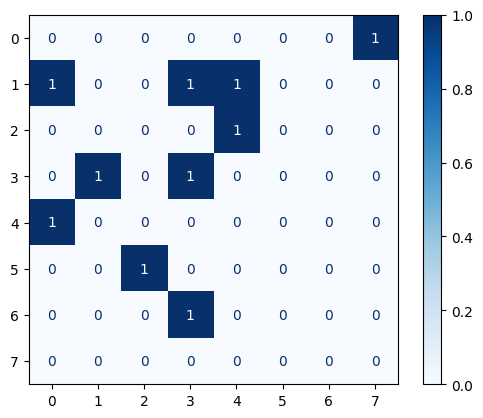

In [31]:
evaluate_model(
    images=test_images_tensor[:10],  # Pass test images tensor
    y_test=test_labels_tensor[:10],  # Pass test labels tensor
    y_pred=y_pred_knn[:10],  # KNN predicted labels
    y_prob=y_proba_knn[:10],  # KNN predicted probabilities
    model_name='KNN',  # Model name
    classes= ['Airplane', 'Bird', 'Car', 'Cat', 'Deer', 'Dog', 'Horse', 'Monkey', 'Ship', 'Truck'],
    num_images=10  # Number of images to display
)


In [ ]:
# Evaluate the model
evaluate_model(
    images=test_images_tensor,  # Use test images tensor here
    y_test=test_labels_tensor,  # Use test labels tensor here
    y_pred=y_pred_log_reg,  # Logistic Regression predicted labels
    y_prob=y_proba_log_reg,  # Logistic Regression predicted probabilities
    model_name='Logistic Regression',  # Model name
    num_images=10  # Number of images to display
)